# Step 0: Setting Up the Environment 

import needed packages

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import tree, svm
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier

## The data cleaning function

In [146]:
def log_transform(value):
    """
    This function does a log transformation for a specific value (negative or positive).
    :param value: The value to transform.
   
 
    :return: The transformed value
    """
    if value > 0:
        return np.log(value)
    elif value == 0:
        return 0
    return -np.log(-value)


def transform(data: pd.DataFrame, 
              inplace=False, 
              trim_long_calls = False,
              trim_poutcome = False,
              trim_age = False,
              log_transformation = True
             ) -> pd.DataFrame | None:
    """
    This function cleans the data frame INPLACE or as a new dataframe.
    :param data: The data frame to clean
    :param inplace: Whether to transform the dataframe in place or as a new dataframe
    :param  drop_long_calls: whether or not you want to drop calls longer than 1000 seconds
    :param trim: Whether tor not you want to drop umknown previous campaign outcome
    :return: The transformed data frame as a new dataframe or None if clean happens in place
    """
    # Make a copy of the dataframe
    df = data if inplace else data.copy()
    # Drop the ID column
    df.drop(columns=['ID'], axis=1, inplace=True)
    # The subscribed (Target column) needs to be a 0/1 column
    df.subscribed = df.subscribed.replace({"yes": 1, "no": 0}).astype(int)
    # we want to handle outliers in the AGE column by cliping (any point > 70 will be 70) or drop them
    if trim_age:
        # Drop outliers
         df = df[df['age'] < 70]
    else:
        # Clip outliers
        df.age = np.where(df.age > 70, 
            70, df.age)
    # Handle the outliers in duration by clipping any rows above 1k to 1k or dropping them
    if trim_long_calls:
        df = df[df['duration'] < 1000]
    else:
        df.duration = np.where(df.duration > 1000, 
            1000, df.duration)
    # we want to handle outliers in the campaign column by cliping (any point > 10 will be 10)
    df.campaign = np.where(df.campaign > 10, 
        10, df.campaign)
    # Replace unknown jobs with others
    df.job = df.job.replace(to_replace="unknown", value="Others")
    # Replace unknown contacts with others
    df.contact = df.contact.replace(to_replace="unknown", value="Others")
    # handle missing values in the poutcome column
    if trim_poutcome:
        # If we want to leave this column we will have to drop any missing values
        df = df[df['poutcome'] != "unknown"]
        df = pd.get_dummies(df, columns=["poutcome"], prefix="P")
    else:
        # Drop that column entirely
        df.drop(columns=['poutcome'], axis=1, inplace=True)
    # Handle outliers in the prevoius column   
    df.previous = np.where(df.previous > 10, 
        10, df.previous)
    # Drop pdays column
    df.drop(columns=['pdays'], axis=1, inplace=True)
    if log_transformation:
        # Log transformation for balance column
        df["log_balance"] = df.balance.apply(log_transform)  
        df.drop(columns=['balance'], axis=1, inplace=True)
        
    # One Hot Encoding for categorical features    
    df = pd.get_dummies(df,columns=["job"], prefix="J")
    df = pd.get_dummies(df,columns=["marital"], prefix="M")
    df = pd.get_dummies(df,columns=["education"], prefix="E")
    df = pd.get_dummies(df,columns=["default"], prefix="D")
    df = pd.get_dummies(df,columns=["housing"], prefix="H")
    df = pd.get_dummies(df,columns=["loan"], prefix="L")
    df = pd.get_dummies(df,columns=["month"], prefix="M")
    df = pd.get_dummies(df,columns=["contact"], prefix="C")
        
    # Return the transformed data frame as a new data frame
    return None if inplace else df

## STEPS
### 1-Split data into train, test, validate.
### 2-EDA on train data.
### 3- Clean and prepare data for the model.
### 4-Model selection.

Load data

In [65]:
## Read data 
data = pd.read_csv("Term Deposit.csv")

### Split the data into train, test, validata (60, 20, 20)

In [66]:
train,test=train_test_split(data,test_size=.4,random_state=0)
test,val=train_test_split(test,test_size=.5,random_state=0)

## step2: EDA on train data

### Getting to know the data

In [5]:
train.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
610,7411,45,admin.,married,secondary,no,142,yes,yes,unknown,29,may,110,3,-1,0,unknown,no
16262,12162,41,management,married,tertiary,no,2031,yes,no,unknown,20,jun,7,3,-1,0,unknown,no
19988,3095,50,unemployed,married,secondary,no,-13,yes,no,unknown,14,may,554,1,-1,0,unknown,no
27156,8473,36,blue-collar,married,secondary,no,16402,yes,no,unknown,3,jun,406,3,-1,0,unknown,no
28152,5488,36,admin.,married,secondary,no,614,yes,no,unknown,23,may,13,5,-1,0,unknown,no


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18988 entries, 610 to 2732
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          18988 non-null  int64 
 1   age         18988 non-null  int64 
 2   job         18988 non-null  object
 3   marital     18988 non-null  object
 4   education   18988 non-null  object
 5   default     18988 non-null  object
 6   balance     18988 non-null  int64 
 7   housing     18988 non-null  object
 8   loan        18988 non-null  object
 9   contact     18988 non-null  object
 10  day         18988 non-null  int64 
 11  month       18988 non-null  object
 12  duration    18988 non-null  int64 
 13  campaign    18988 non-null  int64 
 14  pdays       18988 non-null  int64 
 15  previous    18988 non-null  int64 
 16  poutcome    18988 non-null  object
 17  subscribed  18988 non-null  object
dtypes: int64(8), object(10)
memory usage: 2.8+ MB


In [7]:
train.describe()

,ID,age,balance,day,duration,campaign,pdays,previous
count,18988.000000,18988.000000,18988.000000,18988.000000,18988.000000,18988.000000,18988.000000,18988.000000
mean,22539.078787,40.944228,1346.365705,15.875395,258.776806,2.774805,39.109227,0.569623
std,13056.548871,10.674685,2938.949996,8.304690,257.723311,3.142589,98.735828,2.723189
min,2.000000,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,11221.750000,33.000000,71.000000,8.000000,104.000000,1.000000,-1.000000,0.000000
50%,22451.000000,39.000000,444.000000,16.000000,182.000000,2.000000,-1.000000,0.000000
75%,33850.750000,48.000000,1421.000000,21.000000,320.000000,3.000000,-1.000000,0.000000
max,45211.000000,94.000000,81204.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


### Age Column

In [8]:
## let me see age with target 
train["age"].value_counts()

31    860
32    845
33    834
34    816
35    786
     ... 
88      2
89      1
94      1
92      1
93      1
Name: age, Length: 73, dtype: int64

<Axes: xlabel='age', ylabel='Count'>

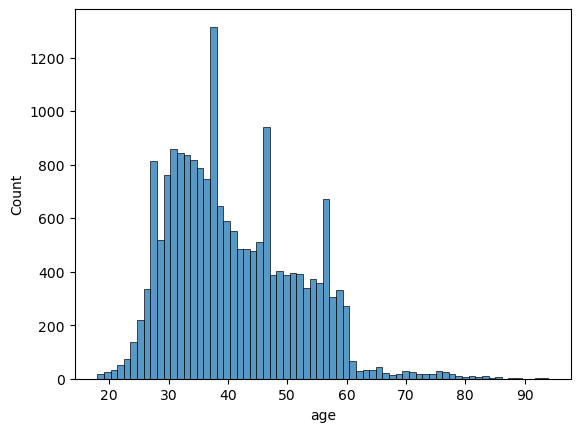

In [9]:
sns.histplot(train["age"])

<Axes: >

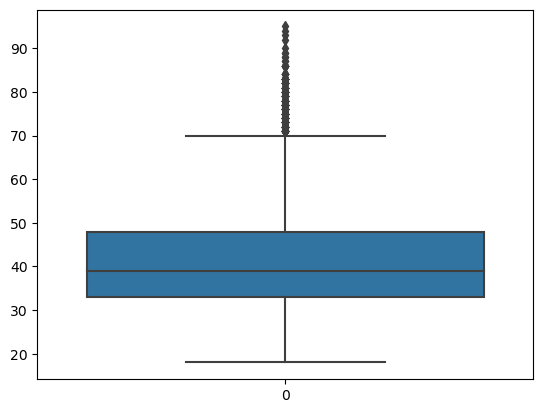

In [10]:
sns.boxplot(data["age"])

In [11]:
train[train["age"]>70]

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
21678,41516,71,retired,married,tertiary,no,14220,yes,no,cellular,9,sep,397,1,-1,0,unknown,yes
4476,31817,71,housemaid,married,primary,no,227,no,no,cellular,8,apr,74,1,-1,0,unknown,no
10941,43932,76,self-employed,married,unknown,no,4984,no,no,telephone,15,jun,126,3,48,2,success,no
10296,43291,77,retired,married,primary,no,29340,no,no,cellular,15,mar,257,1,91,2,other,yes
28780,41507,79,retired,married,secondary,no,723,no,no,telephone,9,sep,276,1,79,3,failure,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15352,42663,81,retired,divorced,tertiary,no,0,no,no,cellular,14,jan,357,1,-1,0,unknown,no
11218,40989,72,retired,married,primary,no,2079,no,no,cellular,13,aug,100,1,191,3,other,no
11052,45110,78,management,married,unknown,no,1780,yes,no,cellular,25,oct,211,2,185,7,success,yes
14447,41759,77,retired,married,primary,no,989,no,no,telephone,12,oct,95,2,-1,0,unknown,no


```python
## we want handle outliers by cliping any point > 70 will be 70 
train.loc[train["age"]>70,"age"]=70
````

<Axes: xlabel='age', ylabel='Count'>

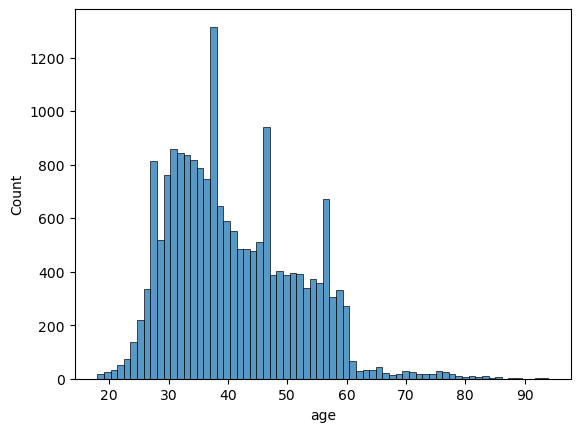

In [12]:
sns.histplot(train["age"])

<Axes: xlabel='age', ylabel='subscribed'>

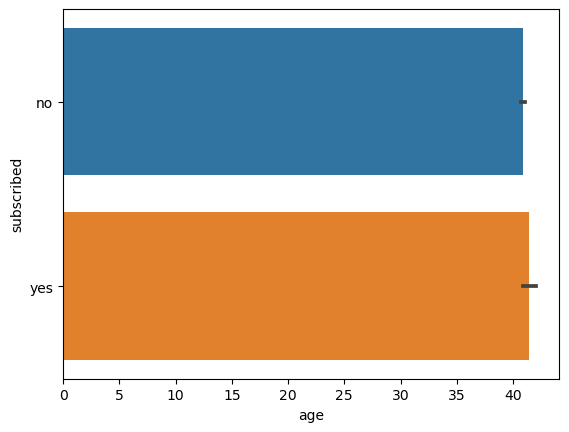

In [13]:
sns.barplot(data=train,x="age",y="subscribed")

### Job

In [14]:
train["job"].value_counts()

blue-collar      4167
management       4034
technician       3129
admin.           2113
services         1723
retired           963
self-employed     693
entrepreneur      620
unemployed        542
housemaid         516
student           363
unknown           125
Name: job, dtype: int64

```python
# Replace unknown jobs with others for better readability.
train.loc[train["job"]=="unknown","job"]="others"
```

<Axes: xlabel='job', ylabel='count'>

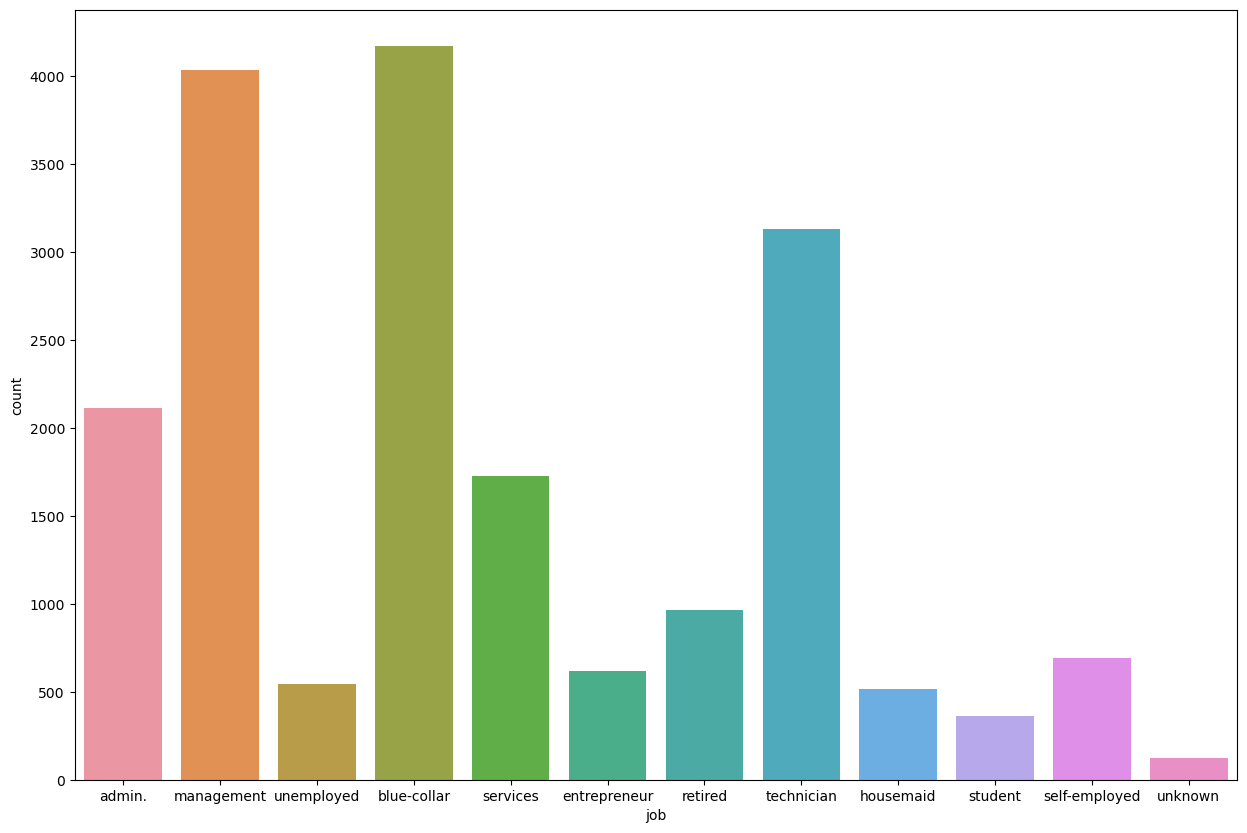

In [15]:
plt.figure(figsize=(15,10))
sns.countplot(data=train,x="job")

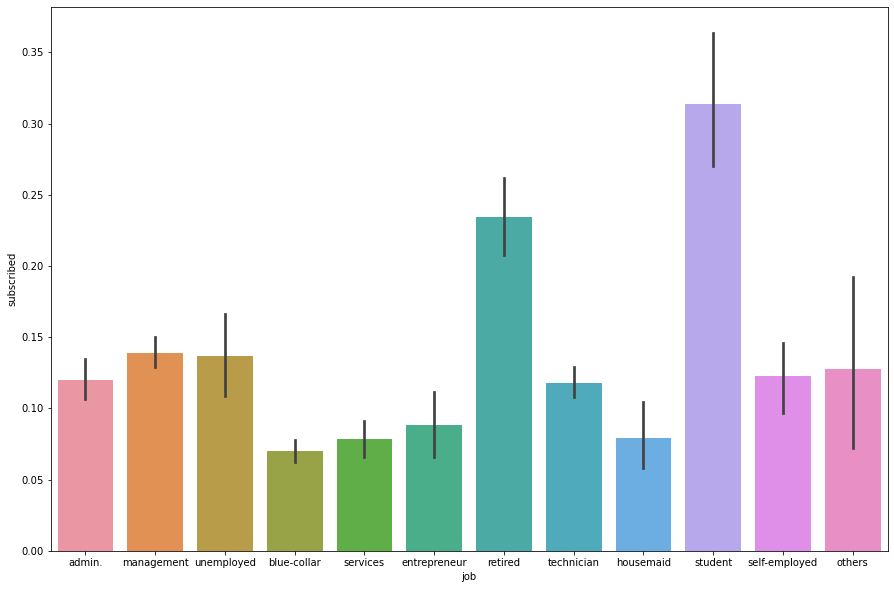

Job needs to be encoded (Using one hot encoding)


### Marital Column

<Axes: xlabel='marital', ylabel='subscribed'>

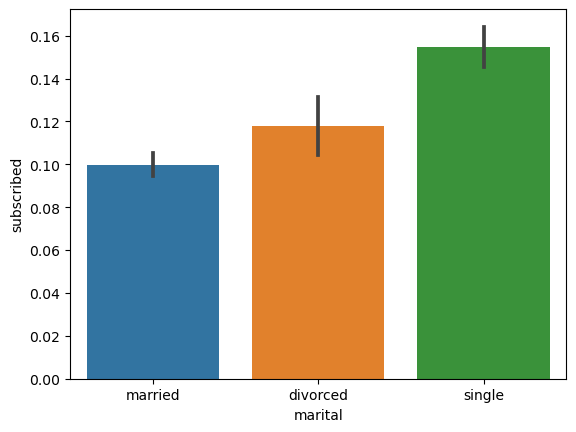

In [16]:
temp = train.copy()
temp['subscribed'] = train.subscribed.replace({"yes": 1, "no": 0}).astype(int)
sns.barplot(data=temp,x="marital",y="subscribed")

Marital column need to be encoded using One Hot Encoding

### Education

In [17]:
train["education"].value_counts()

secondary    9661
tertiary     5609
primary      2951
unknown       767
Name: education, dtype: int64

<Axes: xlabel='education', ylabel='subscribed'>

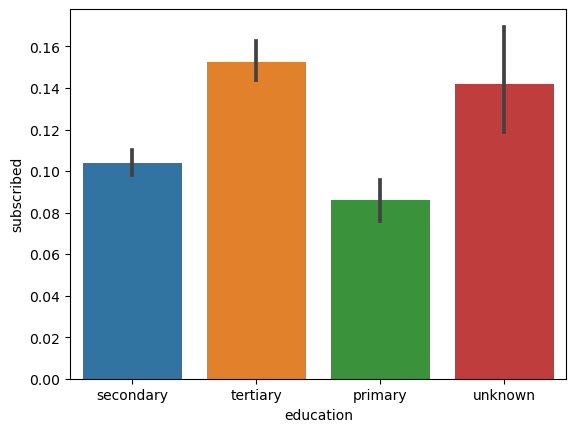

In [19]:
sns.barplot(data=temp,x="education",y="subscribed")

Education column need to be encoded using One Hot Encoding

### Default Column

In [20]:
train["default"].value_counts()

no     18621
yes      367
Name: default, dtype: int64

<Axes: xlabel='default', ylabel='subscribed'>

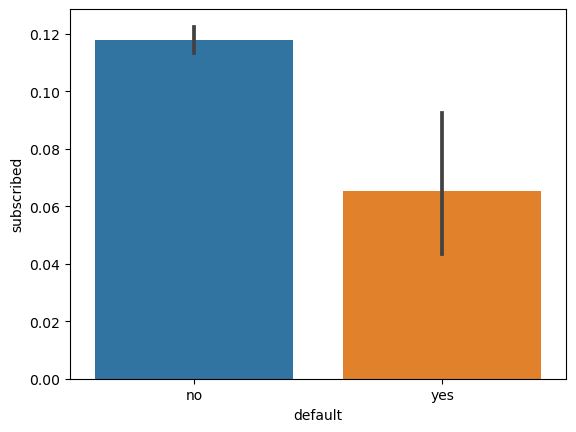

In [22]:
sns.barplot(data=temp,x="default",y="subscribed")

Marital column need to be encoded using One Hot Encoding

### Balance

In [23]:
train["balance"].value_counts()

 0       1495
 1         86
 4         63
 2         62
 6         45
         ... 
 3977       1
-1613       1
 4391       1
-167        1
 2097       1
Name: balance, Length: 5081, dtype: int64

In [24]:
train["balance"].max()

81204

In [25]:
train["balance"].min()

-8019

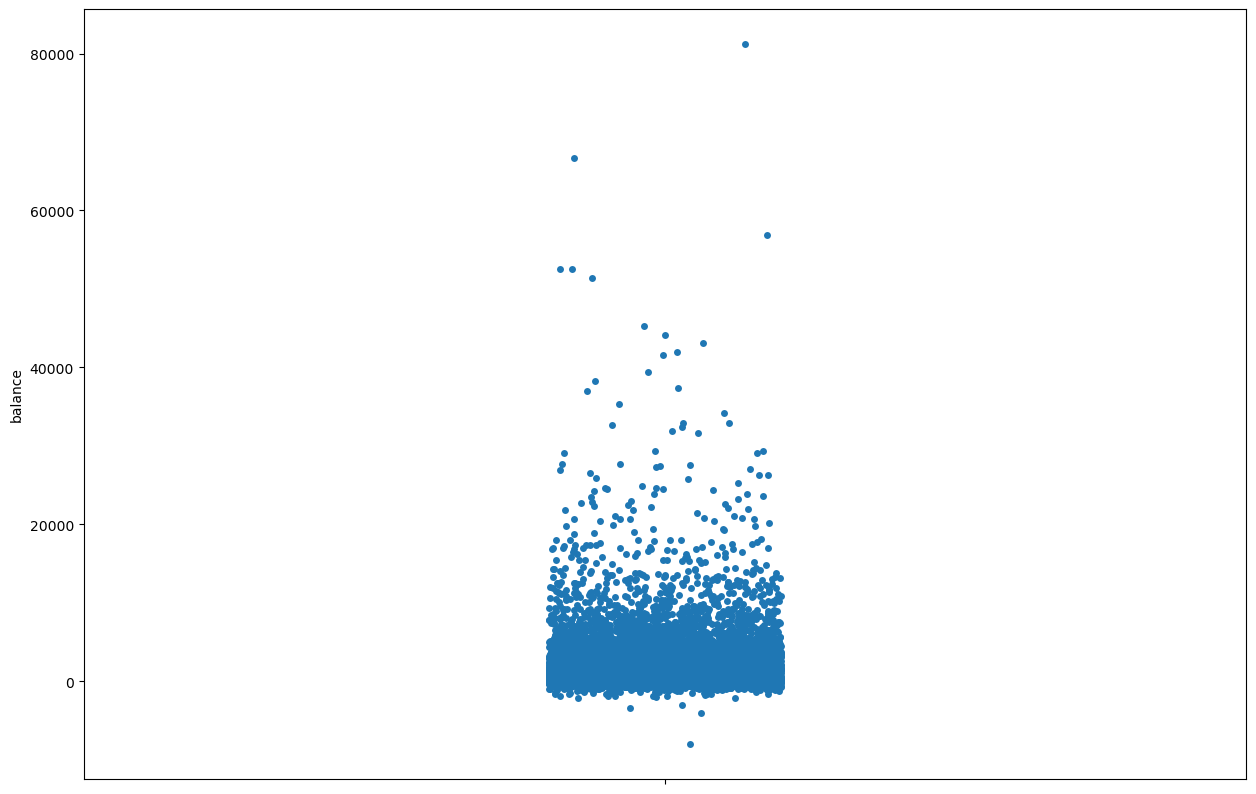

In [31]:
plt.figure(figsize=(15,10))
sns.stripplot(train["balance"])
plt.show()

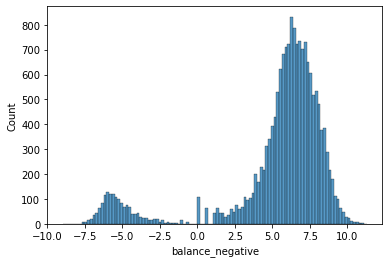

<Axes: xlabel='balance', ylabel='Count'>

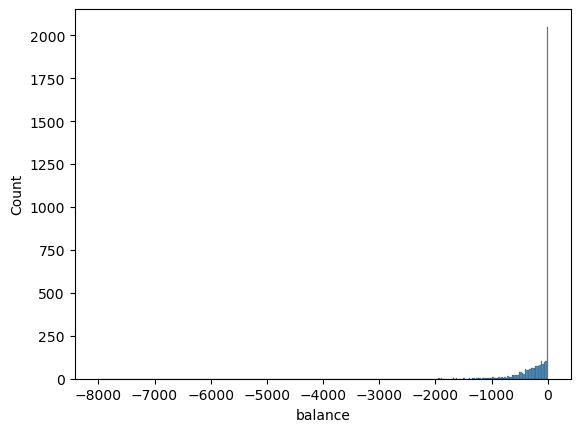

In [33]:
sns.histplot(train[train["balance"]<10].balance)

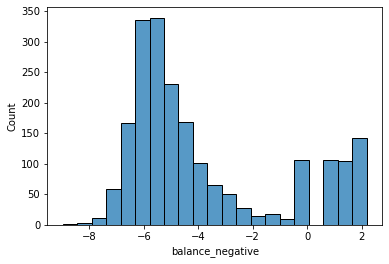

### Housing Column

In [34]:
## housing column  
train["housing"].value_counts()

yes    10627
no      8361
Name: housing, dtype: int64

<Axes: xlabel='housing', ylabel='subscribed'>

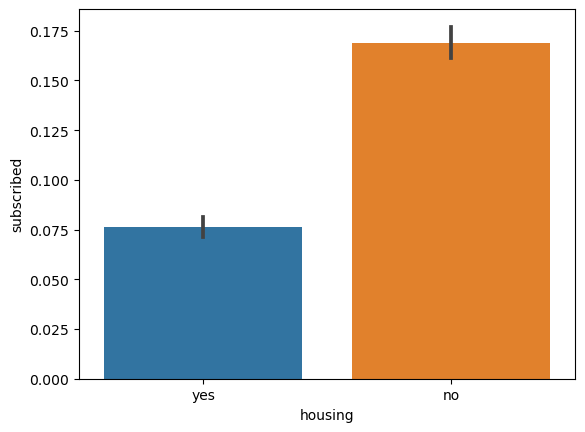

In [36]:
sns.barplot(data=temp,y="subscribed",x="housing")

Housing column needs to be encoded using OHE

### Loan Column

In [37]:
train["loan"].value_counts()

no     15918
yes     3070
Name: loan, dtype: int64

<Axes: xlabel='loan', ylabel='subscribed'>

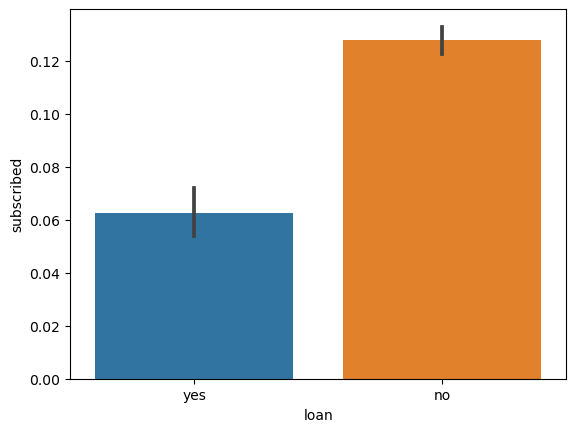

In [38]:
sns.barplot(data=temp,y="subscribed",x="loan")

Loan column needs to be encoded using OHE

### Contact Column

In [39]:
train["contact"].value_counts()

cellular     12268
unknown       5493
telephone     1227
Name: contact, dtype: int64

```python
# replace unknown with others 
train.loc[train["contact"]=="unknown","contact"]="others"
```

<Axes: xlabel='contact', ylabel='subscribed'>

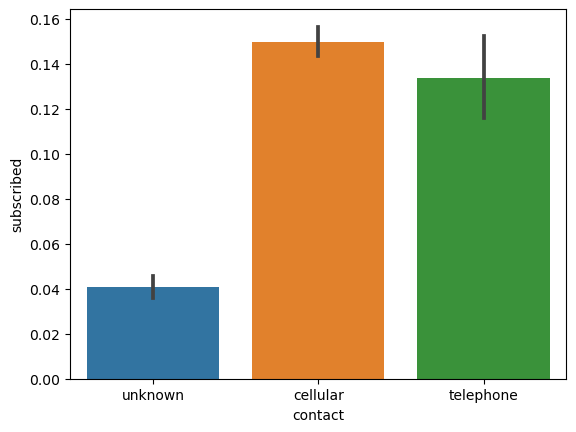

In [40]:
### let me see which most subscribtion 
sns.barplot(data=temp,y="subscribed",x="contact")

Loan column needs to be encoded using OHE

### Day & Month Columns

In [41]:
### let me see day 
train["day"].nunique()

31

In [42]:
train["month"].nunique()

12

In [43]:
train["month"].value_counts()

may    5849
jul    2902
aug    2630
jun    2209
nov    1660
apr    1240
feb    1085
jan     571
oct     301
sep     258
mar     202
dec      81
Name: month, dtype: int64

<Axes: xlabel='month', ylabel='subscribed'>

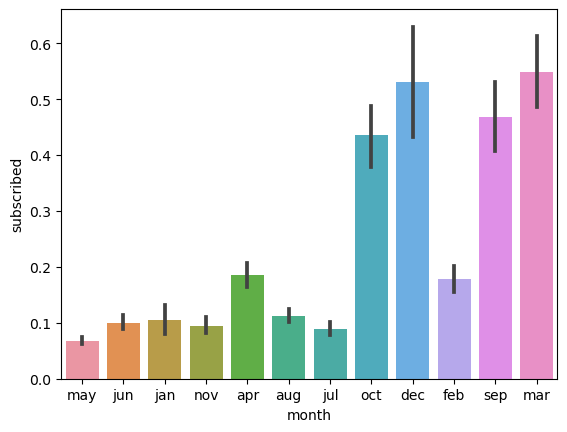

In [44]:
sns.barplot(x=temp.month,y=temp.subscribed)

Month column needs to be one hot enceded

### Duration

<Axes: xlabel='duration', ylabel='Count'>

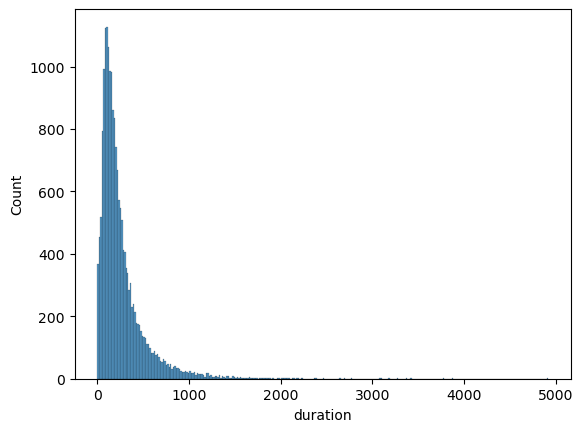

In [45]:
#### duration 
sns.histplot(train.duration)

In [46]:
train.duration.describe()

count    18988.000000
mean       258.776806
std        257.723311
min          0.000000
25%        104.000000
50%        182.000000
75%        320.000000
max       4918.000000
Name: duration, dtype: float64

```python
### handle outliers by cliping or drop them
train.loc[train["duration"]>1000,"duration"]=1000
```

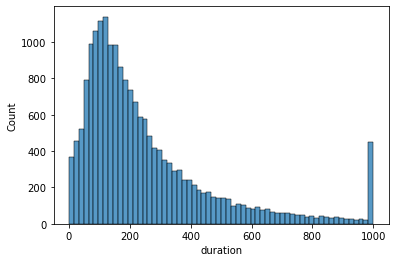

### Campaign

<Axes: xlabel='campaign', ylabel='Count'>

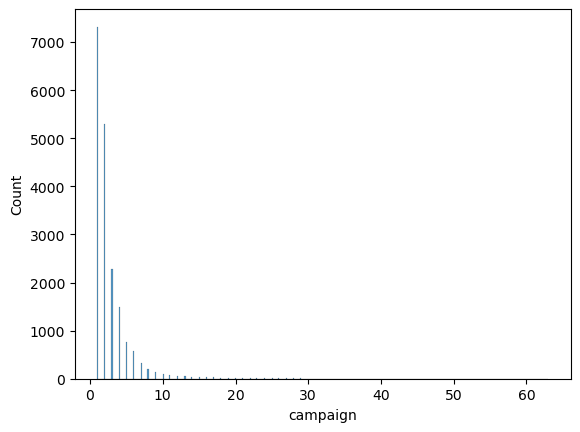

In [47]:
### campaign 
sns.histplot(train["campaign"])

In [49]:
train["campaign"].value_counts()

1     7319
2     5300
3     2284
4     1482
5      758
6      568
7      330
8      204
9      135
10     108
11      76
12      62
13      52
14      46
15      34
16      34
17      33
20      23
18      22
19      20
25      10
29      10
28       9
24       8
23       8
22       8
26       7
27       6
21       5
38       3
30       3
32       3
33       3
34       3
31       2
43       2
55       1
44       1
50       1
37       1
63       1
36       1
35       1
41       1
Name: campaign, dtype: int64

```python
### clipping >10   10
train.loc[train["campaign"]>10,"campaign"]=10
```

### Poutcome

In [50]:
train["poutcome"].value_counts()

unknown    15601
failure     1991
other        749
success      647
Name: poutcome, dtype: int64

```python
### drop  this column or rows with missing values 
train=train.drop(columns=["poutcome"],axis=1)
```

### pdays

In [51]:
train["pdays"].value_counts()

-1      15597
 182       70
 92        58
 91        53
 183       49
        ...  
 415        1
 561        1
 233        1
 616        1
 792        1
Name: pdays, Length: 453, dtype: int64

```python
#### drop this column  
train=train.drop(columns=["pdays"],axis=1)
```

### Previous Column

<Axes: xlabel='previous', ylabel='Count'>

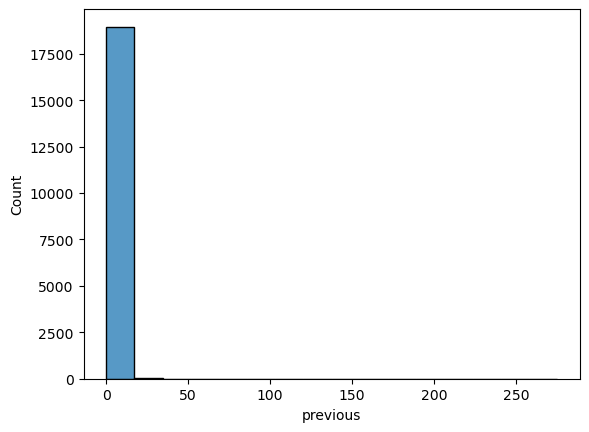

In [52]:
sns.histplot(train["previous"])

In [53]:
train.previous.value_counts()

0      15597
1       1124
2        899
3        457
4        307
5        183
6        100
7         91
8         48
9         42
11        29
10        28
13        15
12         9
14         8
15         8
17         6
16         4
19         4
22         4
25         4
23         4
20         3
27         3
29         2
21         2
41         1
26         1
275        1
38         1
28         1
18         1
58         1
Name: previous, dtype: int64

```python
# We need to clip any values more than 10 to 10
train.loc[train["previous"]>10,"previous"]=10
```

## Transform the data

In [137]:
df = train.copy()
data = transform(df)

The log transformation for the balance Feature

<Axes: xlabel='log_balance', ylabel='Count'>

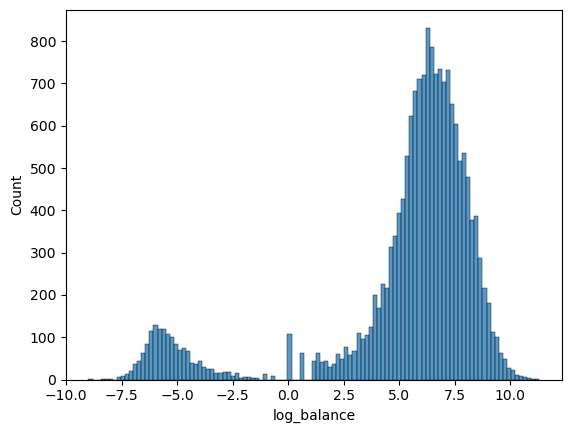

In [138]:
sns.histplot(data.log_balance)

## Getting to know the transformed data

In [139]:
data.head()

,age,day,duration,campaign,previous,subscribed,log_balance,J_Others,J_admin.,J_blue-collar,...,M_jul,M_jun,M_mar,M_may,M_nov,M_oct,M_sep,C_Others,C_cellular,C_telephone
610,45,29,110,3,0,0,4.955827,0,1,0,...,0,0,0,1,0,0,0,1,0,0
16262,41,20,7,3,0,0,7.616284,0,0,0,...,0,1,0,0,0,0,0,1,0,0
19988,50,14,554,1,0,0,-2.564949,0,0,0,...,0,0,0,1,0,0,0,1,0,0
27156,36,3,406,3,0,0,9.705159,0,0,1,...,0,1,0,0,0,0,0,1,0,0
28152,36,23,13,5,0,0,6.419995,0,1,0,...,0,0,0,1,0,0,0,1,0,0


In [140]:
data.describe()

,age,day,duration,campaign,previous,subscribed,log_balance,J_Others,J_admin.,J_blue-collar,...,M_jul,M_jun,M_mar,M_may,M_nov,M_oct,M_sep,C_Others,C_cellular,C_telephone
count,18988.000000,18988.000000,18988.000000,18988.000000,18988.000000,18988.000000,1.898800e+04,18988.000000,18988.000000,18988.000000,...,18988.000000,18988.000000,18988.000000,18988.000000,18988.000000,18988.000000,18988.000000,18988.000000,18988.000000,18988.00000
mean,40.865915,15.875395,250.777070,2.587634,0.517959,0.117074,inf,0.006583,0.111281,0.219454,...,0.152833,0.116337,0.010638,0.308037,0.087424,0.015852,0.013588,0.289288,0.646092,0.06462
std,10.420992,8.304690,216.978669,2.128306,1.483017,0.321517,NaN,0.080871,0.314488,0.413888,...,0.359836,0.320637,0.102595,0.461694,0.282462,0.124907,0.115774,0.453444,0.478194,0.24586
min,18.000000,1.000000,0.000000,1.000000,0.000000,0.000000,-8.989569e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,33.000000,8.000000,104.000000,1.000000,0.000000,0.000000,5.141664e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,39.000000,16.000000,182.000000,2.000000,0.000000,0.000000,6.448098e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000
75%,48.000000,21.000000,320.000000,3.000000,0.000000,0.000000,7.699050e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.00000
max,70.000000,31.000000,1000.000000,10.000000,10.000000,1.000000,inf,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [141]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18988 entries, 610 to 2732
Data columns (total 47 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              18988 non-null  int64  
 1   day              18988 non-null  int64  
 2   duration         18988 non-null  int64  
 3   campaign         18988 non-null  int64  
 4   previous         18988 non-null  int64  
 5   subscribed       18988 non-null  int32  
 6   log_balance      18988 non-null  float64
 7   J_Others         18988 non-null  uint8  
 8   J_admin.         18988 non-null  uint8  
 9   J_blue-collar    18988 non-null  uint8  
 10  J_entrepreneur   18988 non-null  uint8  
 11  J_housemaid      18988 non-null  uint8  
 12  J_management     18988 non-null  uint8  
 13  J_retired        18988 non-null  uint8  
 14  J_self-employed  18988 non-null  uint8  
 15  J_services       18988 non-null  uint8  
 16  J_student        18988 non-null  uint8  
 17  J_technicia

# Modeling

The modeling function

In [143]:
def modeling(train_data: pd.DataFrame, test_data: pd.DataFrame):
      """
    This function fits bunch of ML Regression models.
    :param train_data: The training data for the model
    :param test_data: data to test the model on
    """
    # Get the training features
    train_x = train_data.drop(["subscribed"], axis=1)
    # Get the training labels
    train_y = train_data[['subscribed']]
    # Get the Test features and labels
    test_x = test_data.drop(["subscribed"], axis=1)
    test_y = test_data[['subscribed']]
    
    # Train a Logistic Regression Model
    clf = LogisticRegression(random_state=0).fit(train_x, train_y)
    y_pred_train = clf.predict(train_x)
    y_pred_test = clf.predict(test_x)
    train_score = round(accuracy_score(train_y, y_pred_train), 4)
    test_score = round(accuracy_score(test_y, y_pred_test), 4)
    print(f"For the Logistic Regression Model the accuracy is: \n {train_score} for Training data and {test_score} for test data")
    
    # Train a Decision Tree Model
    model = tree.DecisionTreeClassifier(random_state=0)
    model = model.fit(train_x, train_y)
    y_pred_test = model.predict(test_x)
    y_pred_train = model.predict(train_x)
    train_score = round(accuracy_score(train_y, y_pred_train), 4)
    test_score = round(accuracy_score(test_y, y_pred_test), 4)
    print(f"For the Decision Tree Model the accuracy is: \n {train_score} for Training data and {test_score} for test data")
    
    # Train a Random Forrest model
    model = RandomForestClassifier(random_state=0)
    model = model.fit(train_x, train_y)
    y_pred_test = model.predict(test_x)
    y_pred_train = model.predict(train_x)
    train_score = round(accuracy_score(train_y, y_pred_train), 4)
    test_score = round(accuracy_score(test_y, y_pred_test), 4)
    print(f"For the Random Forrest Model the accuracy is: \n {train_score} for Training data and {test_score} for test data")
    
    # Train SVM Model
    model = svm.SVC(random_state=0)
    model = model.fit(train_x, train_y)
    y_pred_test = model.predict(test_x)
    y_pred_train = model.predict(train_x)
    train_score = round(accuracy_score(train_y, y_pred_train), 4)
    test_score = round(accuracy_score(test_y, y_pred_test), 4)
    print(f"For the SVM Model the accuracy is: \n {train_score} for Training data and {test_score} for test data")
    
    # Ada Boost Model
    model = AdaBoostClassifier(n_estimators=100, random_state=0)
    model = model.fit(train_x, train_y)
    y_pred_test = model.predict(test_x)
    y_pred_train = model.predict(train_x)
    train_score = round(accuracy_score(train_y, y_pred_train), 4)
    test_score = round(accuracy_score(test_y, y_pred_test), 4)
    print(f"For the Ada Boost Model the accuracy is: \n {train_score} for Training data and {test_score} for test data")
    
    # Boosting
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)
    model = model.fit(train_x, train_y)
    y_pred_test = model.predict(test_x)
    y_pred_train = model.predict(train_x)
    train_score = round(accuracy_score(train_y, y_pred_train), 4)
    test_score = round(accuracy_score(test_y, y_pred_test), 4)
    print(f"For the Gradient Boosting Model the accuracy is: \n {train_score} for Training data and {test_score} for test data")
    

## Try with the default data cleaning

In [150]:
train_data = transform(train)
test_data = transform(test)
modeling(train_data, test_data)

C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


For the Logistic Regression Model the accuracy is: 
 0.8889 for Training data and 0.8952 for validation data
For the Decision Tree Model the accuracy is: 
 1.0 for Training data and 0.8719 for validation data


C:\Users\al-ghaly\AppData\Local\Temp\ipykernel_14360\2139288001.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = model.fit(train_x, train_y)


For the Random Forrest Model the accuracy is: 
 1.0 for Training data and 0.9036 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For the SVM Model the accuracy is: 
 0.8884 for Training data and 0.8932 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For the Ada Boost Model the accuracy is: 
 0.8971 for Training data and 0.894 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For the Gradient Boosting Model the accuracy is: 
 0.8993 for Training data and 0.896 for validation data


### We got average accuracy of 89.1% on test data

After trying to enter the poutcome into the model the accuracy decreased so don't need that

In [151]:
train_data = transform(train, trim_age=True)
test_data = transform(test, trim_age=True)
modeling(train_data, test_data)

C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


For the Logistic Regression Model the accuracy is: 
 0.8941 for Training data and 0.8974 for validation data
For the Decision Tree Model the accuracy is: 
 1.0 for Training data and 0.8741 for validation data


C:\Users\al-ghaly\AppData\Local\Temp\ipykernel_14360\2139288001.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = model.fit(train_x, train_y)


For the Random Forrest Model the accuracy is: 
 0.9998 for Training data and 0.9046 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For the SVM Model the accuracy is: 
 0.8919 for Training data and 0.8955 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For the Ada Boost Model the accuracy is: 
 0.8998 for Training data and 0.8991 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For the Gradient Boosting Model the accuracy is: 
 0.9039 for Training data and 0.899 for validation data


### We got average accuracy of 89.5% on test data

In [152]:
train_data = transform(train, trim_age=True, trim_long_calls=True)
test_data = transform(test, trim_age=True, trim_long_calls=True)
modeling(train_data, test_data)

C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


For the Logistic Regression Model the accuracy is: 
 0.9016 for Training data and 0.9037 for validation data
For the Decision Tree Model the accuracy is: 
 1.0 for Training data and 0.88 for validation data


C:\Users\al-ghaly\AppData\Local\Temp\ipykernel_14360\2139288001.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = model.fit(train_x, train_y)


For the Random Forrest Model the accuracy is: 
 0.9999 for Training data and 0.911 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For the SVM Model the accuracy is: 
 0.8989 for Training data and 0.9029 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For the Ada Boost Model the accuracy is: 
 0.9081 for Training data and 0.9058 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For the Gradient Boosting Model the accuracy is: 
 0.911 for Training data and 0.9056 for validation data


### We got average accuracy of 90.15% on test data

In [153]:
train_data = transform(train, trim_age=True, trim_long_calls=True, log_transformation=False)
test_data = transform(test, trim_age=True, trim_long_calls=True, log_transformation=False)
modeling(train_data, test_data)

C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


For the Logistic Regression Model the accuracy is: 
 0.901 for Training data and 0.9024 for validation data
For the Decision Tree Model the accuracy is: 
 1.0 for Training data and 0.8824 for validation data


C:\Users\al-ghaly\AppData\Local\Temp\ipykernel_14360\2139288001.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = model.fit(train_x, train_y)


For the Random Forrest Model the accuracy is: 
 1.0 for Training data and 0.9125 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For the SVM Model the accuracy is: 
 0.8978 for Training data and 0.9016 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For the Ada Boost Model the accuracy is: 
 0.9081 for Training data and 0.9058 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For the Gradient Boosting Model the accuracy is: 
 0.911 for Training data and 0.9056 for validation data


### We got average accuracy of 90.17% on test data

## The best data cleaning is to trim long calls, apply log transformation on balance, 

# Time to test on validation data